In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load the CSV file
df = pd.read_csv("data_homophily.csv")  # Use the correct file path

# Check the first few rows
print(df.head())

   vacc_self  vacc_others01  vacc_others02  vacc_others03  vacc_others04  \
0        5.0              0              0              0              0   
1        5.0              0              0              9              0   
2        5.0              0              0             48              0   
3        5.0             25             15             10              0   
4        5.0              0              0              0            100   

   vacc_others05  masks_self  masks_others_never  masks_others_sometimes  \
0            100         5.0                   0                       0   
1             91         5.0                   0                       0   
2             52         5.0                   4                       0   
3             50         5.0                   6                      15   
4              0         5.0                   0                       0   

   masks_others_half  masks_others_often  masks_others_always  testing_self  \
0      

Text(0.5, 1.0, 'Distribution of Self-reported \n Testing Behavior')

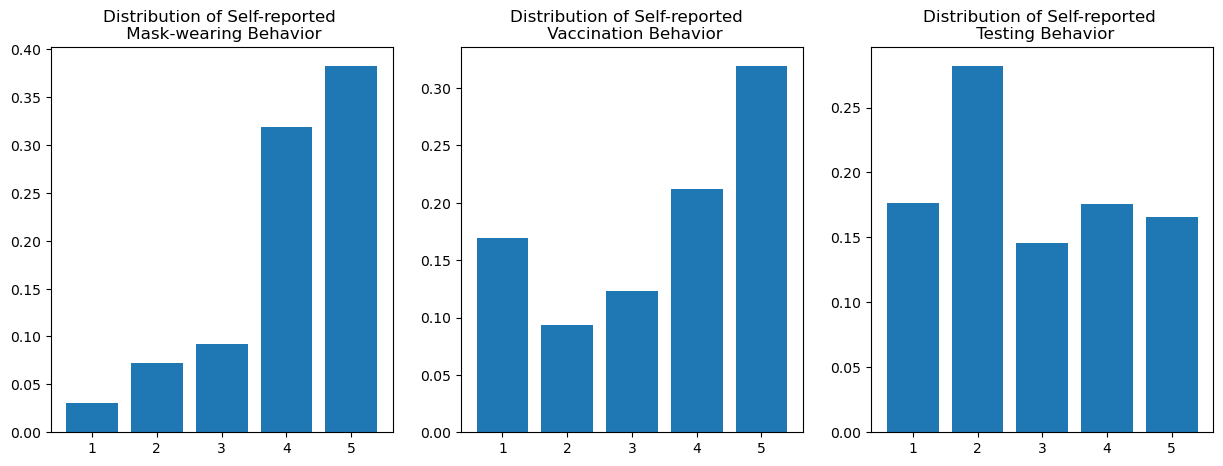

In [4]:
# Get the distribution of self-reported mask-wearing behavior


mask_distribution = df['masks_self'].value_counts().sort_index()
vacc_distribution = df['vacc_self'].value_counts().sort_index()
test_self_distribution = df['testing_self'].value_counts().sort_index()

m_x, m_y = mask_distribution.index, mask_distribution.values/len(df)
v_x, v_y = vacc_distribution.index, vacc_distribution.values/len(df)
t_x, t_y = test_self_distribution.index, test_self_distribution.values/len(df)

# Plot the distribution

fig, axs = plt.subplots(1,3, figsize=(15, 5))

axs[0].bar(m_x, m_y)
axs[0].set_title("Distribution of Self-reported \n Mask-wearing Behavior")

axs[1].bar(v_x, v_y)
axs[1].set_title("Distribution of Self-reported  \n Vaccination Behavior")

axs[2].bar(t_x, t_y)
axs[2].set_title("Distribution of Self-reported \n Testing Behavior")

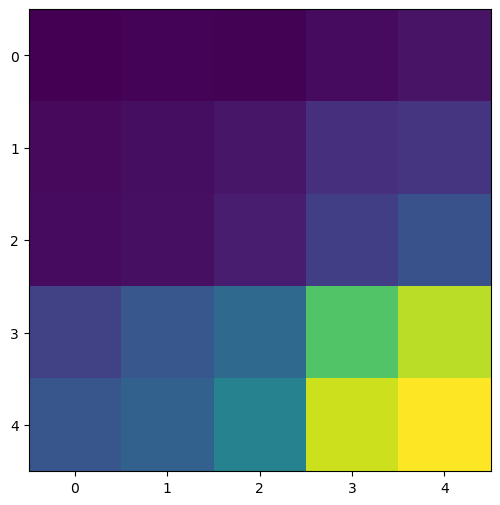

In [5]:
contact_matrix = np.zeros((5, 5))

# focus on mask wearing behavior


df_clean = df.dropna()  # Removes any row with at least one NaN
df_clean = df.dropna().reset_index(drop=True)
mask_self = df_clean['masks_self'].astype(int)-1  # Now it's safe to convert to int

# convert mask_self elements to integers
mask_other_0 = df['masks_others_never']
mask_other_1 = df['masks_others_sometimes']
mask_other_2 = df['masks_others_half']
mask_other_3 = df['masks_others_often']
mask_other_4 = df['masks_others_always']


for i in range(len(mask_self)):
    contact_matrix[mask_self[i], 0] += mask_other_0[i]
    contact_matrix[mask_self[i], 1] += mask_other_1[i]
    contact_matrix[mask_self[i], 2] += mask_other_2[i]
    contact_matrix[mask_self[i], 3] += mask_other_3[i]
    contact_matrix[mask_self[i], 4] += mask_other_4[i]


# divide contact_matrix by the number of people in each mask_self category


# Plot the contact matrix
plt.figure(figsize=(8, 6))
plt.imshow(contact_matrix, cmap='viridis')


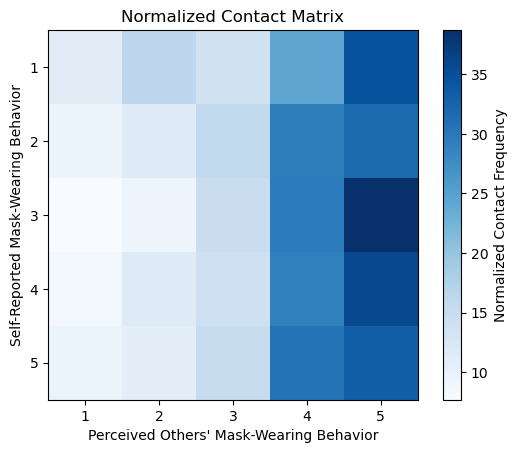

In [9]:
N_i = df_clean['masks_self'].value_counts().sort_index().to_numpy()

# Normalize each row of the contact matrix
contact_matrix_normalized = contact_matrix / N_i[:, None]  # Divide each row by its group size

# Convert to DataFrame for readability
contact_matrix_normalized_df = pd.DataFrame(contact_matrix_normalized, 
                                            index=range(1, 6), 
                                            columns=range(1, 6))

plt.imshow(contact_matrix_normalized_df, cmap="Blues", interpolation="nearest")
plt.colorbar(label="Normalized Contact Frequency")
plt.xlabel("Perceived Others' Mask-Wearing Behavior")
plt.ylabel("Self-Reported Mask-Wearing Behavior")
plt.xticks(range(5), range(1, 6))
plt.yticks(range(5), range(1, 6))
plt.title("Normalized Contact Matrix")
plt.show()

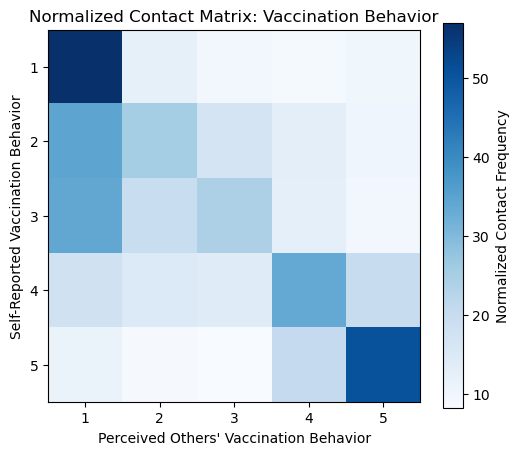

In [6]:
# Recreate the vaccination contact matrix using the correct column names

# Define the correct range of perceived vaccination behavior columns
vacc_others_columns = ['vacc_others01', 'vacc_others02', 'vacc_others03', 'vacc_others04', 'vacc_others05']

# Create an empty contact matrix for vaccination behavior (5x5)
contact_matrix_vacc = np.zeros((5, 5))

# Iterate over self-reported vaccination behavior and perceived others' behavior
for i, self_value in enumerate(range(1, 6)):  # Self-reported behavior (1 to 5)
    for j, col in enumerate(vacc_others_columns):  # Corresponding perceived behavior columns
        contact_matrix_vacc[i, j] = df_clean[df_clean['vacc_self'] == self_value][col].sum()

# Convert to DataFrame for readability
contact_matrix_vacc_df = pd.DataFrame(contact_matrix_vacc, index=range(1, 6), columns=range(1, 6))

# Normalize: Divide each row by the total number of people in that self-reported category
N_i_vacc = df_clean['vacc_self'].value_counts().sort_index().to_numpy()
contact_matrix_vacc_normalized = contact_matrix_vacc / N_i_vacc[:, None]

# Convert normalized matrix to DataFrame
contact_matrix_vacc_normalized_df = pd.DataFrame(contact_matrix_vacc_normalized, index=range(1, 6), columns=range(1, 6))

# Display the normalized contact matrix as an interactive table

# Plot the heatmap of the normalized contact matrix
plt.figure(figsize=(6, 5))
plt.imshow(contact_matrix_vacc_normalized_df, cmap="Blues", interpolation="nearest")

# Add labels and title
plt.colorbar(label="Normalized Contact Frequency")
plt.xlabel("Perceived Others' Vaccination Behavior")
plt.ylabel("Self-Reported Vaccination Behavior")
plt.xticks(range(5), range(1, 6))
plt.yticks(range(5), range(1, 6))
plt.title("Normalized Contact Matrix: Vaccination Behavior")

# Show the heatmap
plt.show()


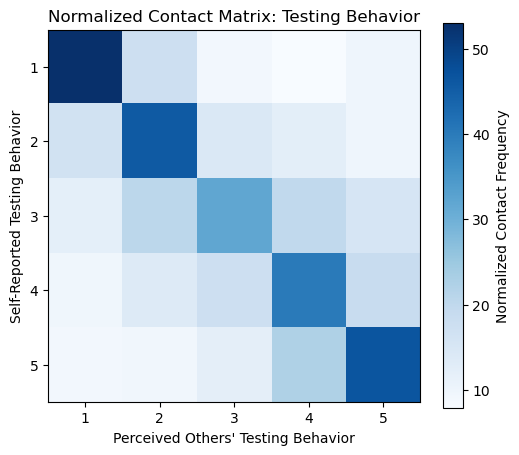

In [7]:
# Define the correct range of perceived testing behavior columns
testing_others_columns = [
    'testing_others_never', 'testing_others_sometimes', 
    'testing_others_half', 'testing_others_often', 'testing_others_always'
]

# Create an empty contact matrix for testing behavior (5x5)
contact_matrix_testing = np.zeros((5, 5))

# Iterate over self-reported testing behavior and perceived others' behavior
for i, self_value in enumerate(range(1, 6)):  # Self-reported behavior (1 to 5)
    for j, col in enumerate(testing_others_columns):  # Corresponding perceived behavior columns
        contact_matrix_testing[i, j] = df_clean[df_clean['testing_self'] == self_value][col].sum()

# Convert to DataFrame for readability
contact_matrix_testing_df = pd.DataFrame(contact_matrix_testing, index=range(1, 6), columns=range(1, 6))

# Normalize: Divide each row by the total number of people in that self-reported category
N_i_testing = df_clean['testing_self'].value_counts().sort_index().to_numpy()
contact_matrix_testing_normalized = contact_matrix_testing / N_i_testing[:, None]

# Convert normalized matrix to DataFrame
contact_matrix_testing_normalized_df = pd.DataFrame(contact_matrix_testing_normalized, index=range(1, 6), columns=range(1, 6))

# Display the normalized contact matrix as an interactive table

# Plot the heatmap of the normalized contact matrix
plt.figure(figsize=(6, 5))
plt.imshow(contact_matrix_testing_normalized_df, cmap="Blues", interpolation="nearest")

# Add labels and title
plt.colorbar(label="Normalized Contact Frequency")
plt.xlabel("Perceived Others' Testing Behavior")
plt.ylabel("Self-Reported Testing Behavior")
plt.xticks(range(5), range(1, 6))
plt.yticks(range(5), range(1, 6))
plt.title("Normalized Contact Matrix: Testing Behavior")

# Show the heatmap
plt.show()


In [8]:
print(mask_self.head())  # Check the index and values
print(mask_self.index)  # Inspect the actual indices

0    4
1    4
2    4
3    4
4    4
Name: masks_self, dtype: int32
RangeIndex(start=0, stop=1360, step=1)


[Text(0, 0, '1'),
 Text(0, 1, '2'),
 Text(0, 2, '3'),
 Text(0, 3, '4'),
 Text(0, 4, '5')]

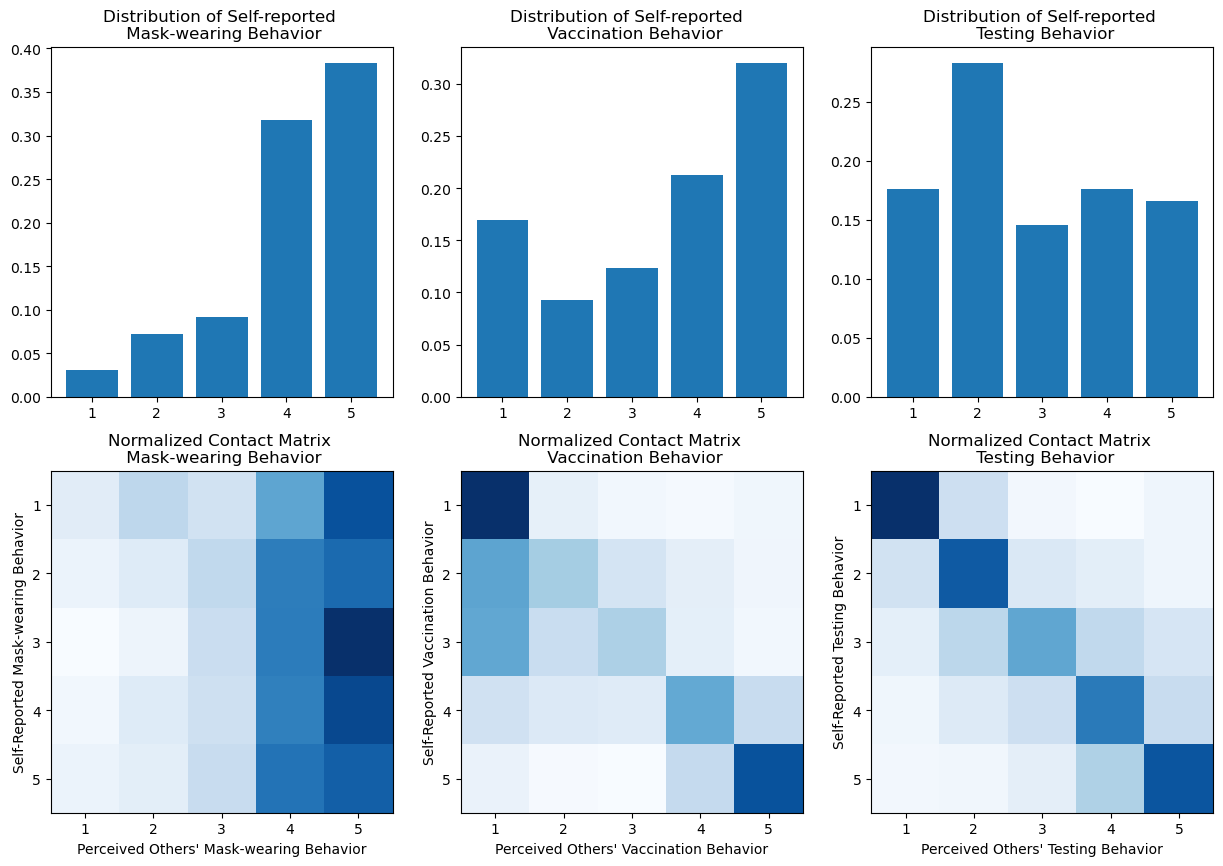

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot the distribution of perceived mask-wearing behavior for each self-reported category

axs[0,0].bar(m_x, m_y)
axs[0,0].set_title("Distribution of Self-reported \n Mask-wearing Behavior")

axs[0,1].bar(v_x, v_y)
axs[0,1].set_title("Distribution of Self-reported  \n Vaccination Behavior")

axs[0,2].bar(t_x, t_y)
axs[0,2].set_title("Distribution of Self-reported \n Testing Behavior")


# Plot the normalized contact matrix for mask-wearing behavior

axs[1,0].imshow(contact_matrix_normalized_df, cmap="Blues", interpolation="nearest")
axs[1,0].set_title("Normalized Contact Matrix \n Mask-wearing Behavior")
axs[1,0].set_xlabel("Perceived Others' Mask-wearing Behavior")
axs[1,0].set_ylabel("Self-Reported Mask-wearing Behavior")
axs[1,0].set_xticks(range(5))
axs[1,0].set_yticks(range(5))
axs[1,0].set_xticklabels(range(1, 6))
axs[1,0].set_yticklabels(range(1, 6))

# Plot the normalized contact matrix for vaccination behavior

axs[1,1].imshow(contact_matrix_vacc_normalized_df, cmap="Blues", interpolation="nearest")
axs[1,1].set_title("Normalized Contact Matrix \n Vaccination Behavior")
axs[1,1].set_xlabel("Perceived Others' Vaccination Behavior")
axs[1,1].set_ylabel("Self-Reported Vaccination Behavior")
axs[1,1].set_xticks(range(5))
axs[1,1].set_yticks(range(5))
axs[1,1].set_xticklabels(range(1, 6))
axs[1,1].set_yticklabels(range(1, 6))

# Plot the normalized contact matrix for testing behavior

axs[1,2].imshow(contact_matrix_testing_normalized_df, cmap="Blues", interpolation="nearest")
axs[1,2].set_title("Normalized Contact Matrix \n Testing Behavior")
axs[1,2].set_xlabel("Perceived Others' Testing Behavior")
axs[1,2].set_ylabel("Self-Reported Testing Behavior")
axs[1,2].set_xticks(range(5))
axs[1,2].set_yticks(range(5))
axs[1,2].set_xticklabels(range(1, 6))
axs[1,2].set_yticklabels(range(1, 6))
